# Finding Correlations between Returns of Different Time Frames

## Imports

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

## Load Data

In [7]:
F_TUdf = pd.read_csv('data/F_TU_history.csv', skiprows=1)
F_TUdf.columns = ['Date', 'Price', 'Open', 'High', 'Low', 'Vol', 'Change %']
F_TUdf['Date'] = pd.to_datetime(F_TUdf['Date'], errors='coerce')
F_TUdf['Price'] = pd.to_numeric(F_TUdf['Price'], errors='coerce')

## Logic

In [8]:
def backshift(n, series):
    if isinstance(series, pd.Series):
        return series.shift(n)
    elif isinstance(series, np.ndarray):
        return np.roll(series, n)
    else:
        raise TypeError("Input should be either a Pandas Series or a numpy array")


def fwdshift(n, series):
    return series.shift(-n)

results = []
for lookback in [1, 5, 10, 25, 60, 120, 250]:
    for holddays in [1, 5, 10, 25, 60, 120, 250]:
        ret_lag = (F_TUdf['Price'] - backshift(lookback, F_TUdf['Price'])) / backshift(lookback, F_TUdf['Price'])
        ret_fut = (fwdshift(holddays, F_TUdf['Price']) - F_TUdf['Price']) / F_TUdf['Price']
        
        valid_data = ~np.isnan(ret_lag) & ~np.isnan(ret_fut)
        ret_lag = ret_lag[valid_data]
        ret_fut = ret_fut[valid_data]
        
        if lookback >= holddays:
            indepSet = np.arange(0, len(ret_lag), lookback)
        else:
            indepSet = np.arange(0, len(ret_lag), holddays)
        
        ret_lag = ret_lag.iloc[indepSet]
        ret_fut = ret_fut.iloc[indepSet]

        cc, p_val = pearsonr(ret_lag, ret_fut)
        
        results.append({
            'Look-back': lookback,
            'Holding days': holddays,
            'Correlation coefficient': cc,
            'p-value': p_val
        })

results_df = pd.DataFrame(results)

filtered_results = results_df[results_df['Look-back'].isin([25, 60, 120, 250])]

print("Correlations between TU Returns of Different Time Frames")
print(filtered_results)

Correlations between TU Returns of Different Time Frames
    Look-back  Holding days  Correlation coefficient   p-value
21         25             1                -0.253341  0.008786
22         25             5                -0.148243  0.129380
23         25            10                -0.094745  0.334008
24         25            25                 0.152091  0.121421
25         25            60                 0.428995  0.003665
26         25           120                 0.553904  0.007481
27         25           250                 0.049099  0.892854
28         60             1                -0.162242  0.292707
29         60             5                 0.115866  0.453877
30         60            10                 0.096093  0.534929
31         60            25                 0.400346  0.007086
32         60            60                 0.245343  0.112794
33         60           120                 0.363660  0.105125
34         60           250                 0.804013  0.00505

## TU Momentum Strategy

In [9]:
lookback = 25
holddays = 120

longs = F_TUdf['Price'] > backshift(lookback, F_TUdf['Price'])
shorts = F_TUdf['Price'] < backshift(lookback, F_TUdf['Price'])
pos = np.zeros(len(F_TUdf))

for h in range(holddays):
    long_lag = backshift(h, longs).fillna(False)
    short_lag = backshift(h, shorts).fillna(False)
    
    pos[long_lag] += 1
    pos[short_lag] -= 1

## Returns and Plotting

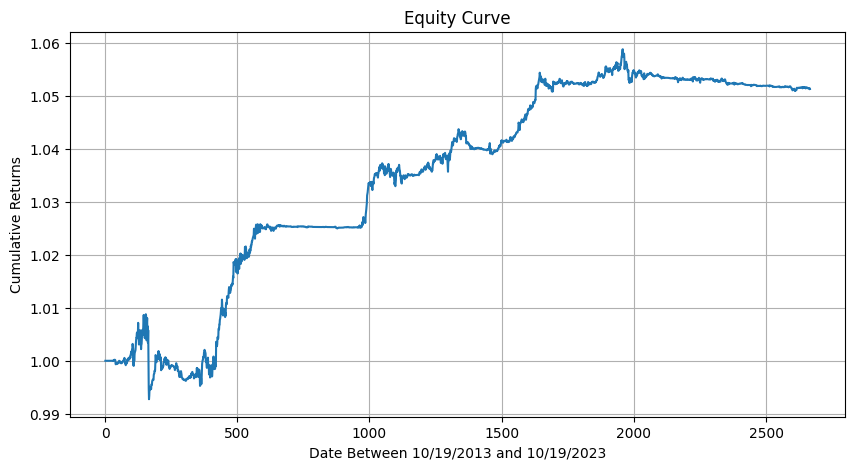

Sharpe Ratio: 0.0418
APR: 0.48%


In [10]:
lagged_price = backshift(1, F_TUdf['Price'])
returns = (backshift(1, pos) * (F_TUdf['Price'] - lagged_price) / lagged_price) / holddays

cumulative_returns = (1 + returns).cumprod()

# Plotting the equity curve
plt.figure(figsize=(10, 5))
cumulative_returns.plot(title='Equity Curve')
plt.xlabel('Date Between 10/19/2013 and 10/19/2023')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

risk_free_rate = 0

average_daily_return = returns.mean()
std_daily_return = returns.std()

# Sharpe Ratio
sharpe_ratio = (average_daily_return - risk_free_rate) / std_daily_return

# Calculate the APR
apr = ((1 + average_daily_return) ** 252) - 1

print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"APR: {apr*100:.2f}%")